In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features=0.3)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.02)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('Combined_all_3rd_fit.csv', encoding='cp1252')
print(data.columns.values)  

['Name' 'Coef_a' 'Coef_b' 'Coef_c' 'Coef_d' 'A_site' 'B_site' 'X_site'
 'Spacegroup' 'Ehull' 'BulkModulus' 'Energy' 'ZPE' 's_A' 's_B' 's_X'
 'density' 'mean_A2B' 'mean_A2X' 'mean_B2X' 'mean_X2X' 'std_A2B' 'std_A2X'
 'std_B2X' 'std_X2X' 'E_coh' 'TF' 'OF' 'A_Z' 'B_Z' 'X_Z' 'A_M' 'B_M' 'X_M'
 'A_G' 'B_G' 'X_G' 'A_IEI' 'B_IEI' 'X_IEI' 'A_IEII' 'B_IEII' 'X_IEII'
 'A_EA' 'B_EA' 'X_EA' 'A_ChiP' 'B_ChiP' 'X_ChiP' 'A_ChiA' 'X_ChiA'
 'A_Rvdw' 'B_Rvdw' 'X_Rvdw' 'A_Rc' 'B_Rc' 'X_Rc' 'A_Ra' 'B_Ra' 'X_Ra'
 'A_MP' 'B_MP' 'X_MP' 'A_BP' 'B_BP' 'X_BP' 'A_Rho' 'B_Rho' 'A_MV' 'B_MV'
 'X_MV' 'A_Hf' 'B_Hf' 'X_Hf' 'A_Hv' 'B_Hv' 'X_Hv' 'A_Kappa' 'B_Kappa'
 'X_Kappa' 'A_CvM' 'B_CvM' 'X_CvM' 'A_B' 'B_B' 'X_B' 'A_MendeleevNo'
 'B_MendeleevNo' 'X_MendeleevNo']


In [6]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup','BulkModulus',
           'Ehull','Energy','ZPE','Coef_b', 'Coef_c', 'Coef_d'], axis=1, inplace = True)
target = 'Coef_a'

In [7]:
data.fillna(0, inplace= True)
d=data.copy()
columns = list(d.columns.values)

# Standard Scaling

In [8]:
data_std=d.copy()
scaler=StandardScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_std= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [9]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


### Test-train splitting 

In [10]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state =50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.8935344679187889
RMSE:  0.3259234573781208
RMSE unscaled:  9.353950508811177e-09
----------------------------------------


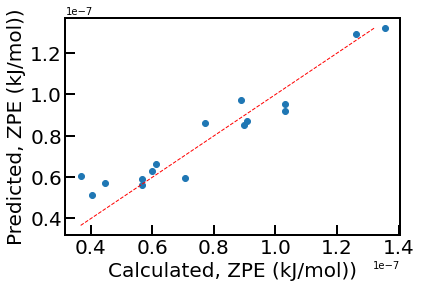

GB 0.8050279551799555
RMSE:  0.4410595981471063
RMSE unscaled:  1.2658339125673293e-08
----------------------------------------


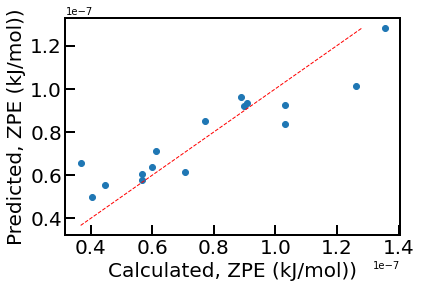

RR 0.7417602789693631
RMSE:  0.5076011836617395
RMSE unscaled:  1.4568071866878217e-08
----------------------------------------


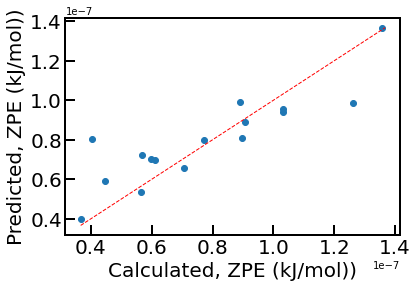

LASSO 0.8721837887323263
RMSE:  0.3571116959399117
RMSE unscaled:  1.0249047910854056e-08
----------------------------------------


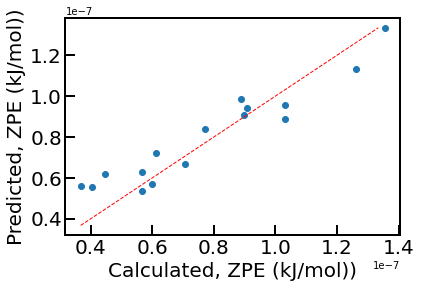

gpr1 0.8161989168841137
RMSE:  0.4282379361584458
RMSE unscaled:  1.2290359500495547e-08
----------------------------------------


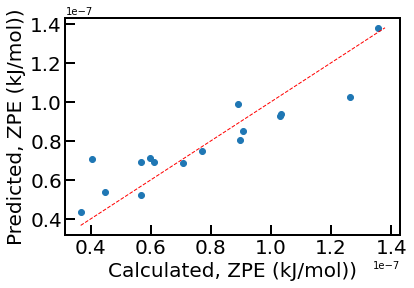

gpr2 0.9269060747492823
RMSE:  0.2700547040342196
RMSE unscaled:  7.750526324581497e-09
----------------------------------------


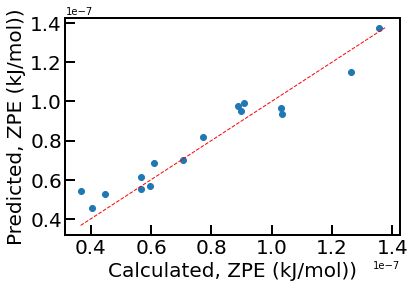

gpr3 0.9259945257104498
RMSE:  0.2717334028286776
RMSE unscaled:  7.798704708453828e-09
----------------------------------------


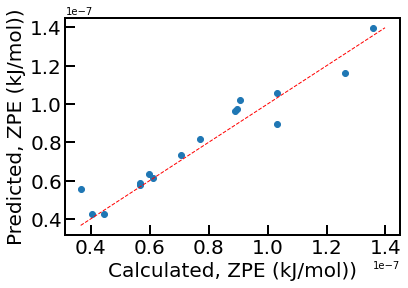

gpr4 0.9327548285485431
RMSE:  0.2590249847529864
RMSE unscaled:  7.4339751652611615e-09
----------------------------------------


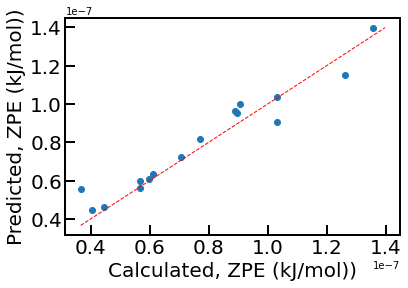

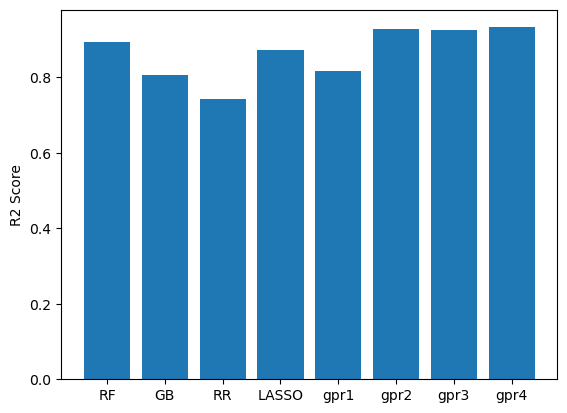

In [11]:
run_models()

In [12]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  109.296724
2        s_X   88.595605
28      X_EA   73.368669
35      X_Ra   73.296860
17       X_Z   66.718735
7   mean_X2X   56.945060
33    A_Rvdw   51.699207
0        s_A   41.011777
5   mean_A2X   40.526215
1        s_B   33.215949
20     A_IEI   32.506577
12     E_coh   30.740923
31    A_ChiA   16.249435
9    std_A2X   15.249756
29    A_ChiP   14.642045
25    X_IEII   14.270340
26      A_EA   13.518905
42      B_Hf   13.440569
45   X_Kappa   12.439648
36      B_MP   11.182324
37      A_BP   10.591541
43   A_Kappa    8.683247
32    X_ChiA    8.650691
10   std_B2X    8.580932
15       A_Z    8.474870
44   B_Kappa    8.031022
16       B_Z    6.255140
46     A_CvM    5.656104
18       A_G    5.063472
14        OF    4.732281


In [13]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_EA', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'X_IEII', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP', 'A_BP',
       'A_Kappa', 'X_ChiA', 'std_B2X', 'A_Z', 'B_Kappa', 'B_Z', 'A_CvM',
       'A_G', 'OF', 'B_Ra', 'X_IEI', 'A_B', 'std_A2B', 'B_EA', 'B_Rho',
       'X_MV', 'density', 'B_IEI', 'B_ChiP'], dtype=object)

In [14]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9244644967650689
RMSE:  0.27452801360160023
RMSE unscaled:  7.878909585609946e-09
----------------------------------------


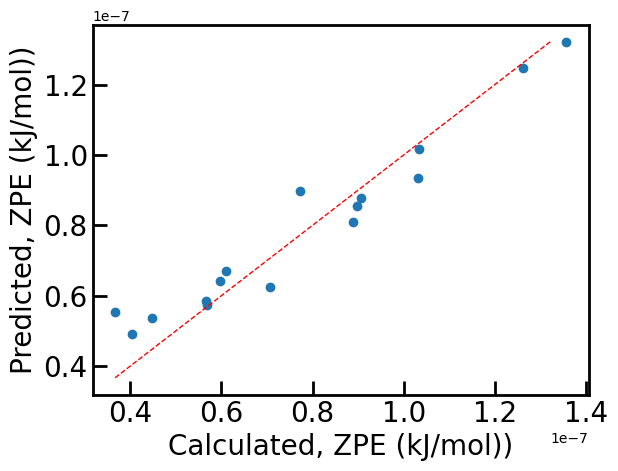

GB 0.825052674655237
RMSE:  0.4177964618679983
RMSE unscaled:  1.1990690877262458e-08
----------------------------------------


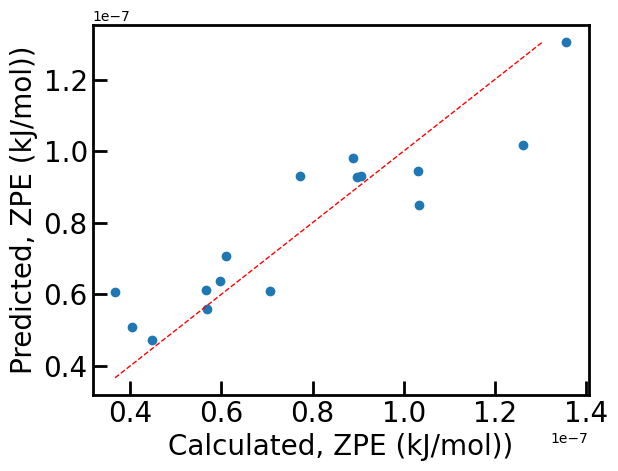

RR 0.8090534595641681
RMSE:  0.4364826660403419
RMSE unscaled:  1.2526981914525418e-08
----------------------------------------


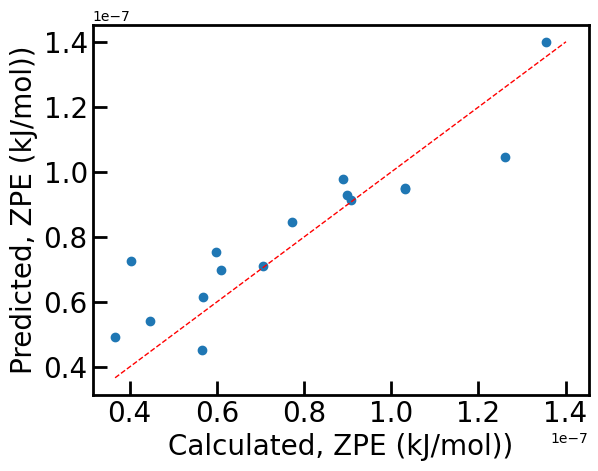

LASSO 0.8719088590182027
RMSE:  0.3574955591296756
RMSE unscaled:  1.026006472231062e-08
----------------------------------------


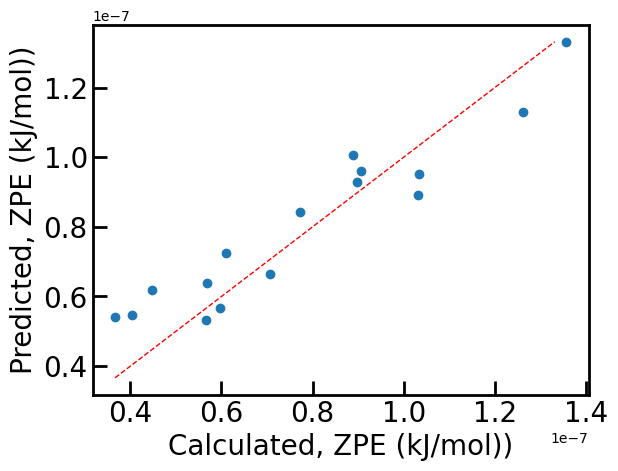

gpr1 0.8144268946509456
RMSE:  0.4302973007929565
RMSE unscaled:  1.23494629324049e-08
----------------------------------------


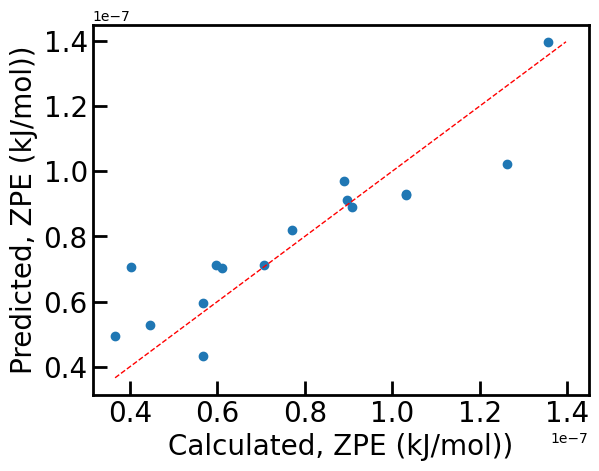

gpr2 0.9182333878901502
RMSE:  0.2856268997977464
RMSE unscaled:  8.197445824200572e-09
----------------------------------------


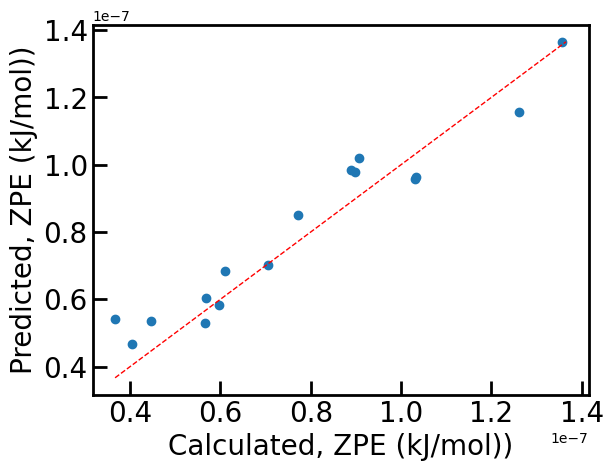

gpr3 0.8973293651207923
RMSE:  0.3200620834641157
RMSE unscaled:  9.185730025553252e-09
----------------------------------------


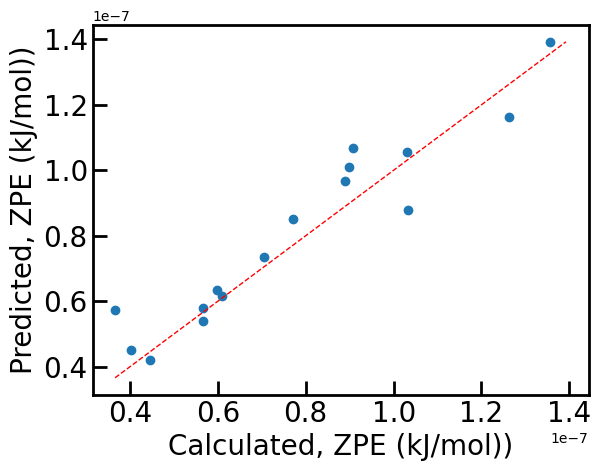

gpr4 0.9192232727328986
RMSE:  0.2838927036979584
RMSE unscaled:  8.147674676641928e-09
----------------------------------------


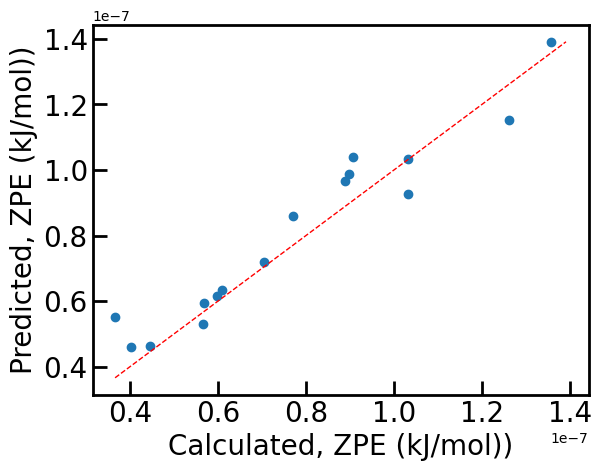

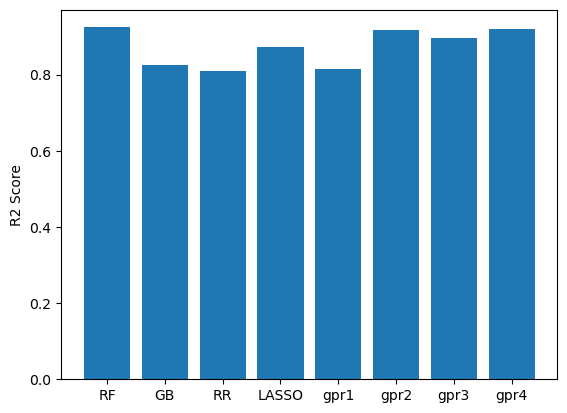

In [15]:
run_models()

In [16]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_EA', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'X_IEII', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP', 'A_BP',
       'A_Kappa', 'X_ChiA', 'std_B2X', 'A_Z', 'B_Kappa', 'B_Z', 'A_CvM',
       'A_G', 'OF'], dtype=object)

In [17]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.891255484705131
RMSE:  0.3293933181497811
RMSE unscaled:  9.453534951709747e-09
----------------------------------------


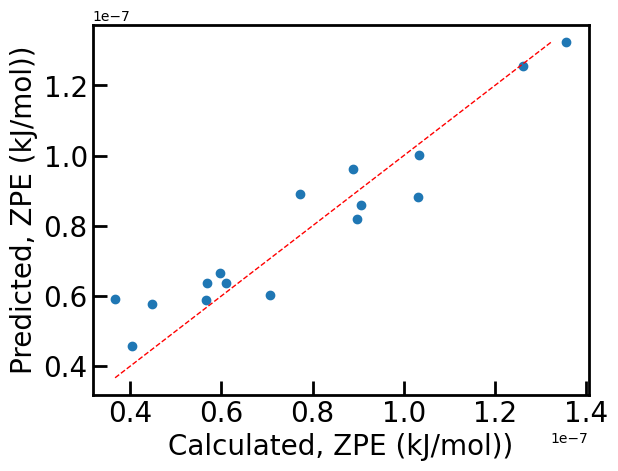

GB 0.8112772183536064
RMSE:  0.4339335894009722
RMSE unscaled:  1.245382382728726e-08
----------------------------------------


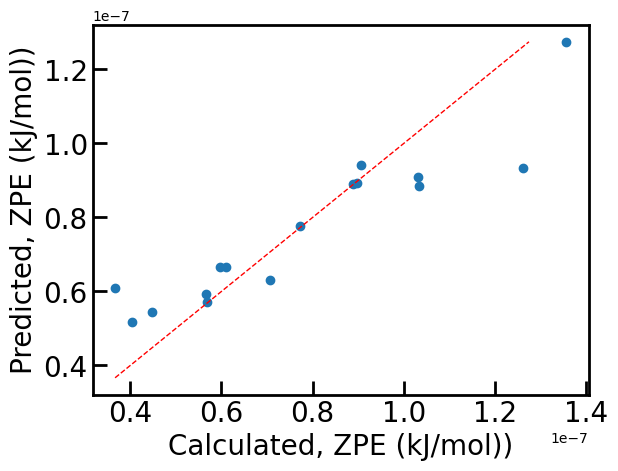

RR 0.7189676378077061
RMSE:  0.5295284166942971
RMSE unscaled:  1.5197379908194677e-08
----------------------------------------


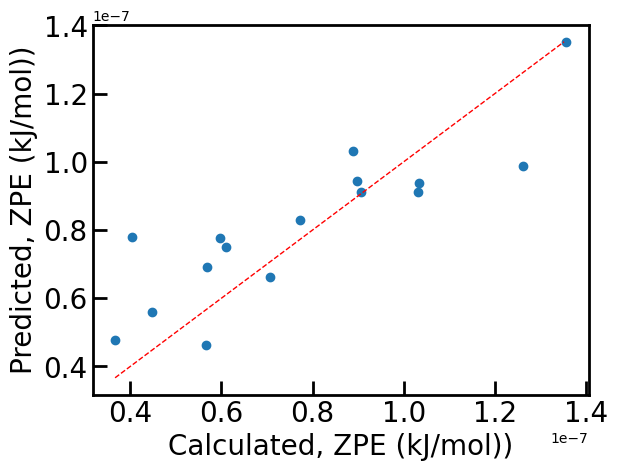

LASSO 0.8906333917263288
RMSE:  0.33033415201251487
RMSE unscaled:  9.480536731390843e-09
----------------------------------------


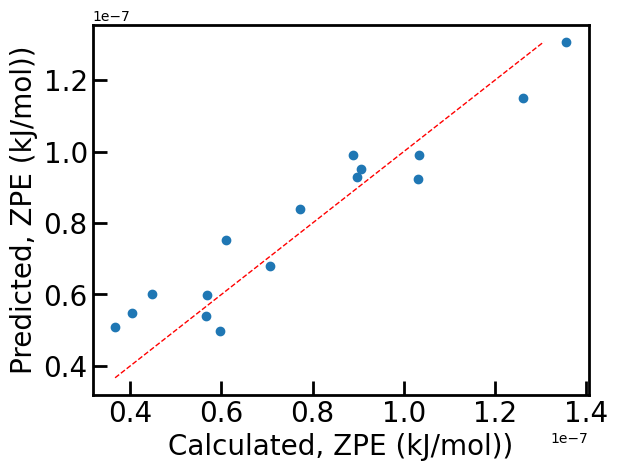

gpr1 0.7917442321341097
RMSE:  0.45583705223419424
RMSE unscaled:  1.3082449667727605e-08
----------------------------------------


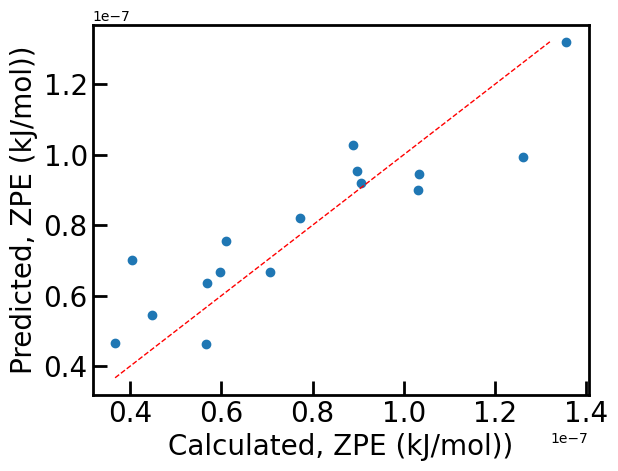

gpr2 0.9255017557548998
RMSE:  0.2726365785625405
RMSE unscaled:  7.824625705927514e-09
----------------------------------------


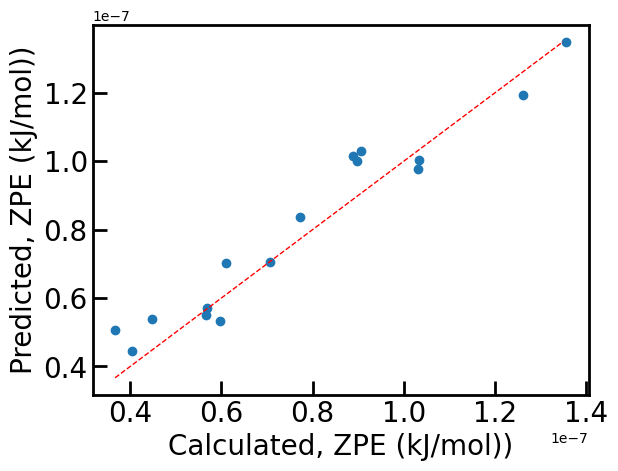

gpr3 0.9092057816135465
RMSE:  0.3009817765891112
RMSE unscaled:  8.63812830446982e-09
----------------------------------------


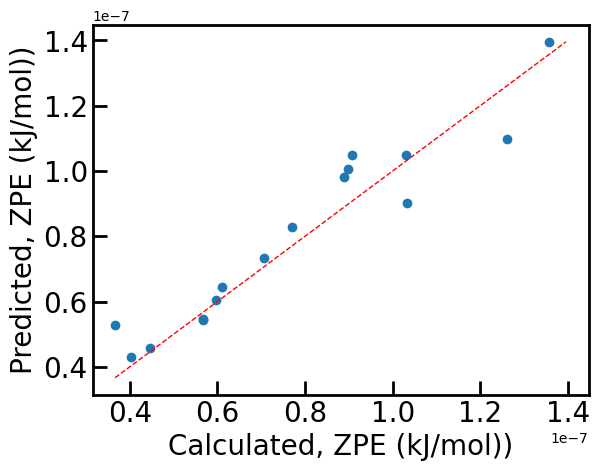

gpr4 0.9193129268655126
RMSE:  0.2837351136269772
RMSE unscaled:  8.143151867094872e-09
----------------------------------------


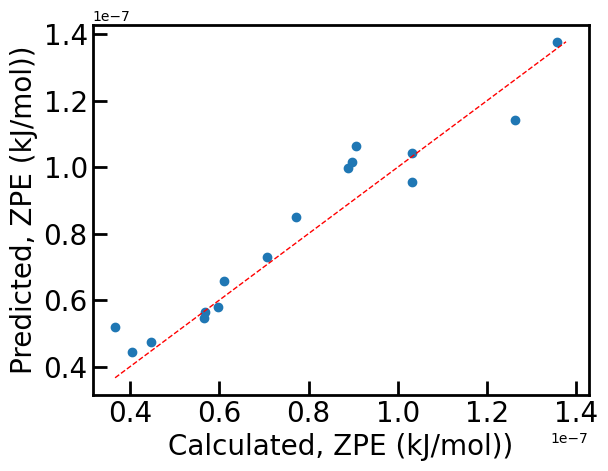

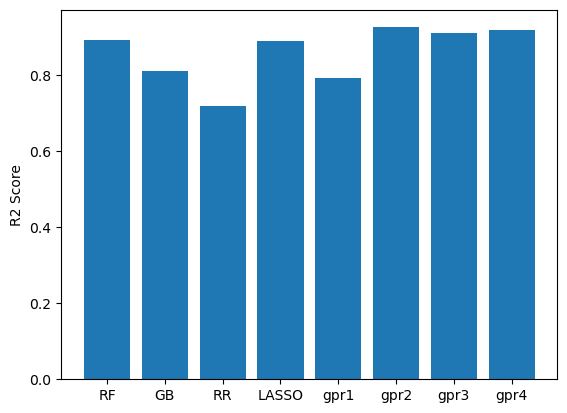

In [18]:
run_models()

In [19]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_EA', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'X_IEII', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP'],
      dtype=object)

In [20]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.8031261964210729
RMSE:  0.4432054275179225
RMSE unscaled:  1.2719924081528992e-08
----------------------------------------


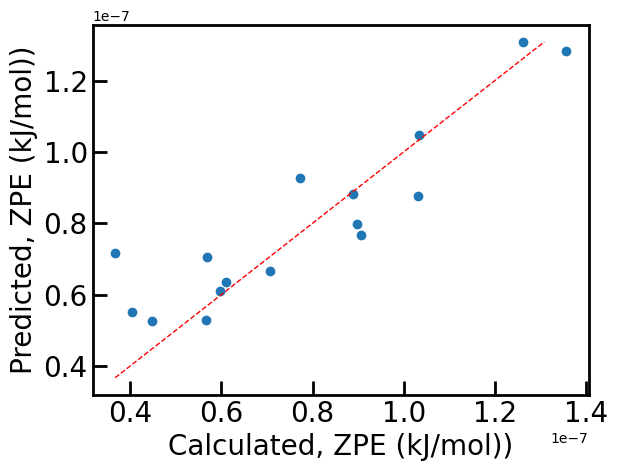

GB 0.8570442465251332
RMSE:  0.3776695090014008
RMSE unscaled:  1.0839053820503778e-08
----------------------------------------


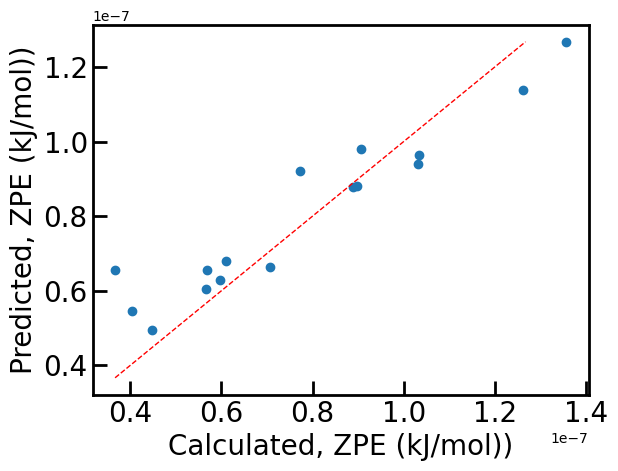

RR 0.8768202957481179
RMSE:  0.35057479013035137
RMSE unscaled:  1.0061439771460612e-08
----------------------------------------


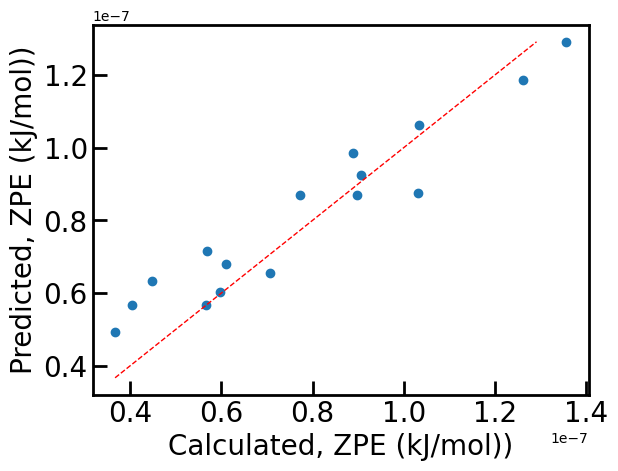

LASSO 0.8955593500282804
RMSE:  0.3228091878325084
RMSE unscaled:  9.264571476583494e-09
----------------------------------------


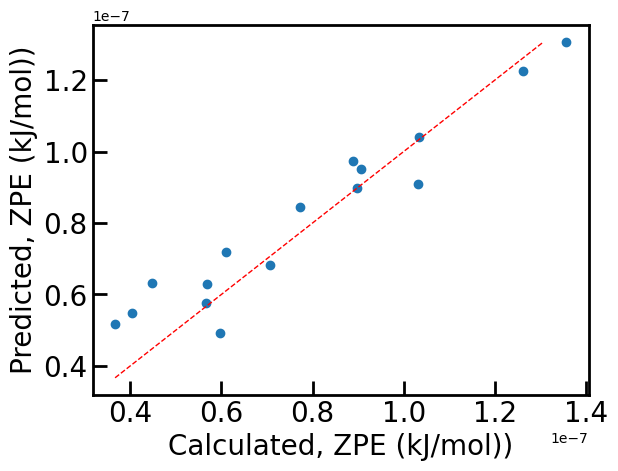

gpr1 0.8896955086520428
RMSE:  0.33174753328411677
RMSE unscaled:  9.521100545272173e-09
----------------------------------------


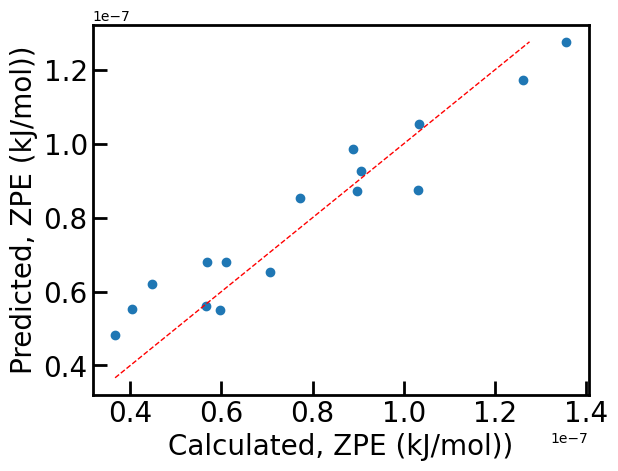

gpr2 0.9256271710849379
RMSE:  0.27240699456651485
RMSE unscaled:  7.818036682376663e-09
----------------------------------------


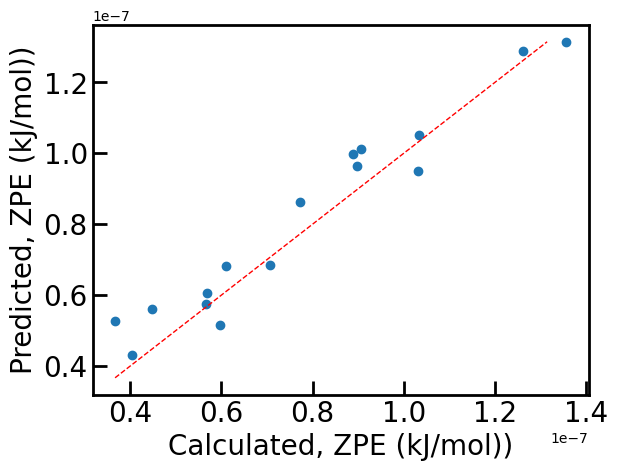

gpr3 0.9012304206111693
RMSE:  0.31392268940958457
RMSE unscaled:  9.00953040923184e-09
----------------------------------------


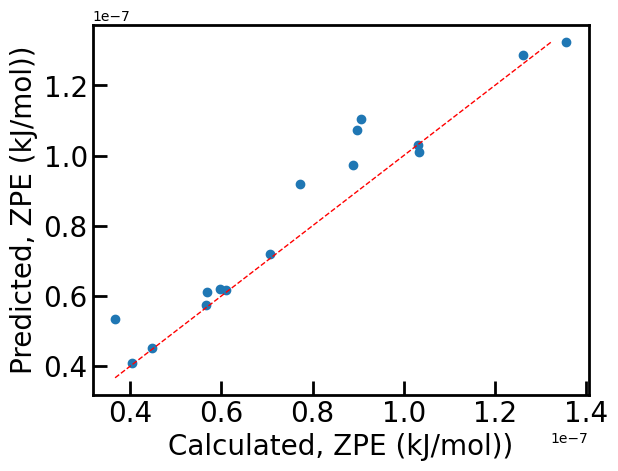

gpr4 0.9149561835848319
RMSE:  0.2912946275457425
RMSE unscaled:  8.360108693816198e-09
----------------------------------------


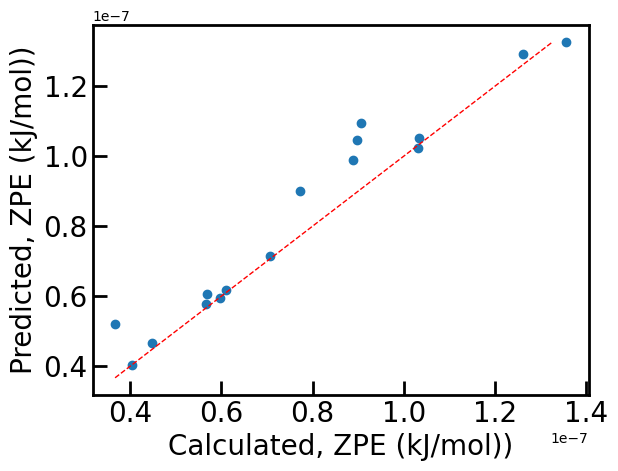

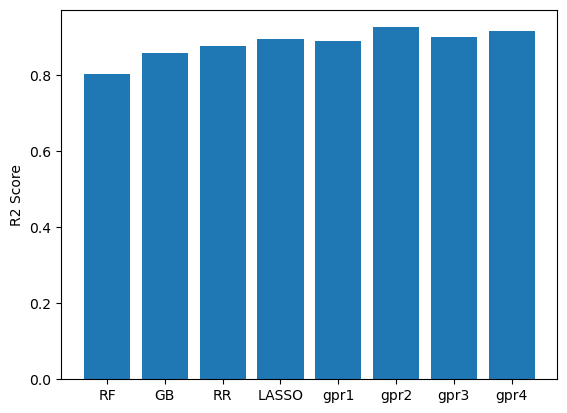

In [21]:
run_models()

In [22]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_EA', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B'], dtype=object)

In [23]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8683851538067433
RMSE:  0.36237943580279375
RMSE unscaled:  1.0400231192864732e-08
----------------------------------------


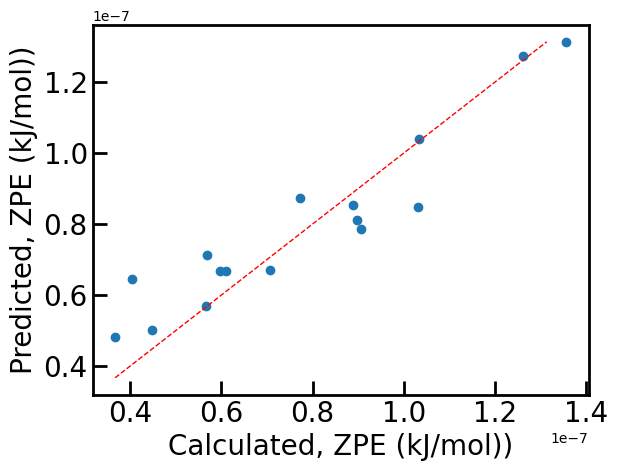

GB 0.8898948584664226
RMSE:  0.33144761931058375
RMSE unscaled:  9.512493062742693e-09
----------------------------------------


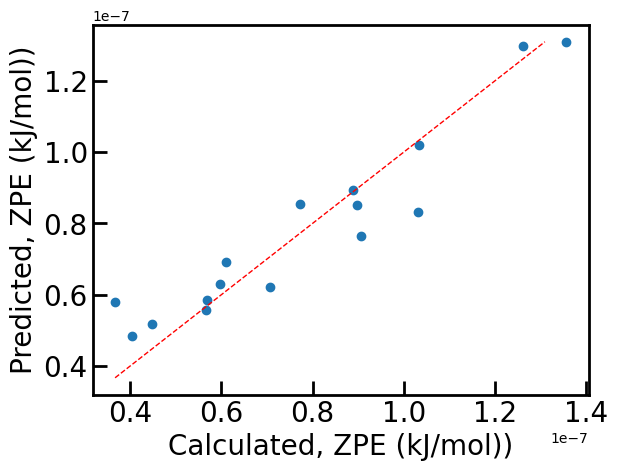

RR 0.9303840239077938
RMSE:  0.2635515426385091
RMSE unscaled:  7.563886644407402e-09
----------------------------------------


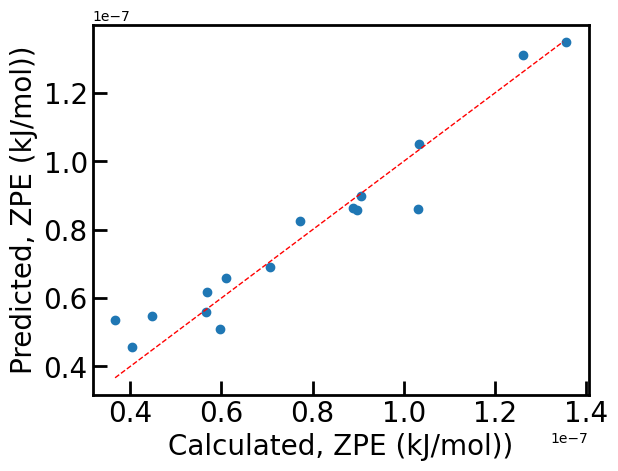

LASSO 0.9148142454070396
RMSE:  0.2915376116520845
RMSE unscaled:  8.367082298365668e-09
----------------------------------------


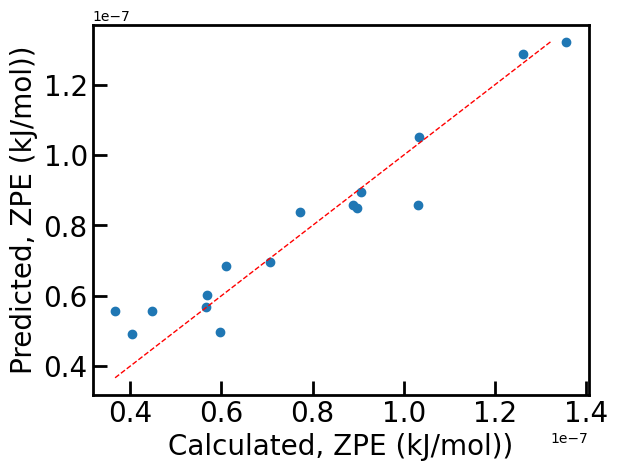

gpr1 0.9292178086796494
RMSE:  0.26574989771491575
RMSE unscaled:  7.626979079517543e-09
----------------------------------------


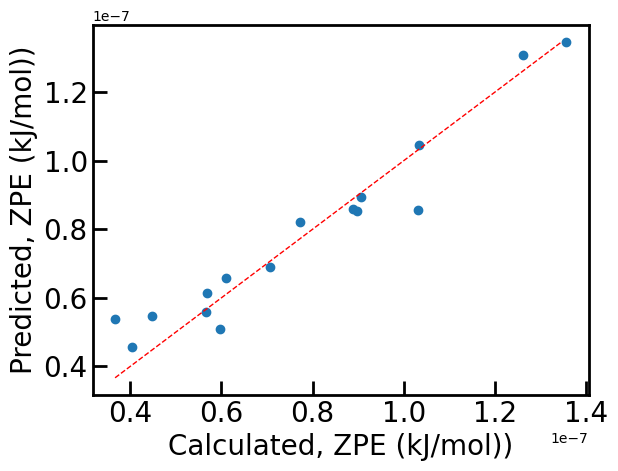

gpr2 0.944014120214476
RMSE:  0.2363471435382931
RMSE unscaled:  6.78312479052787e-09
----------------------------------------


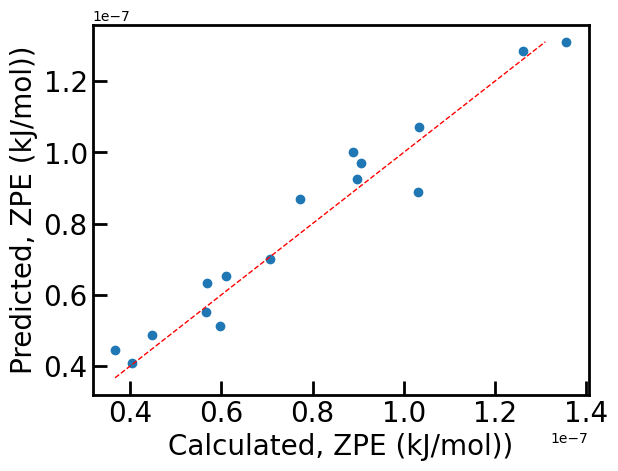

gpr3 0.961173195012463
RMSE:  0.19682349141880376
RMSE unscaled:  5.648802367627631e-09
----------------------------------------


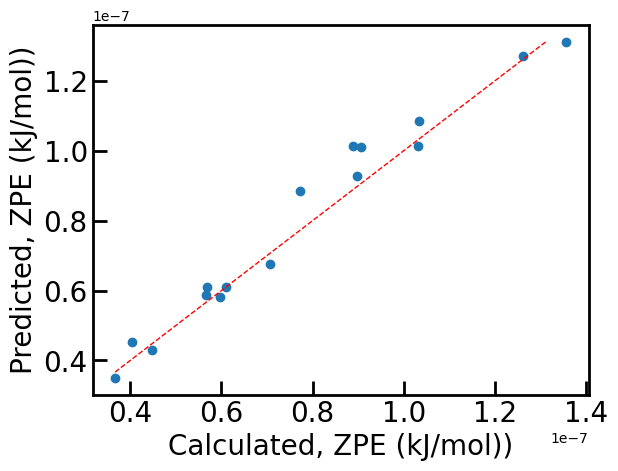

gpr4 0.9429596385931742
RMSE:  0.2385625336042655
RMSE unscaled:  6.8467061270831454e-09
----------------------------------------


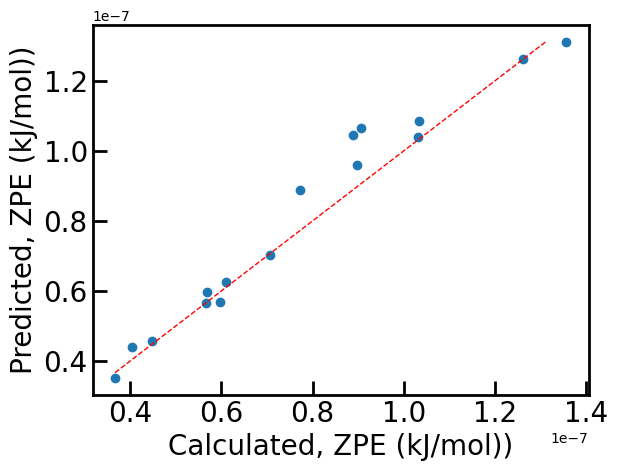

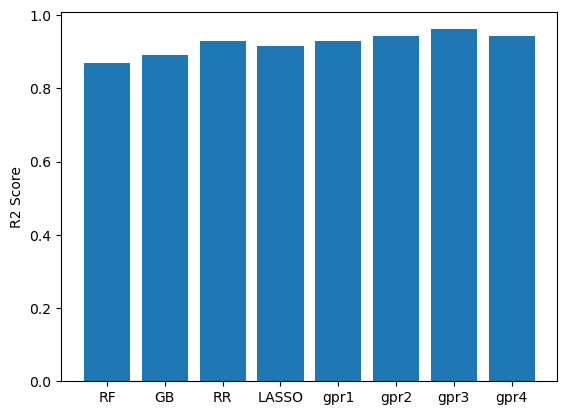

In [24]:
run_models()

# Min-Max scaling

In [25]:
data_std=d.copy()
scaler=MinMaxScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_mm= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [26]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


### Test-train splitting 

In [27]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.821836889677071
RMSE:  0.09960625853084507
RMSE unscaled:  1.2100392179714643e-08
----------------------------------------


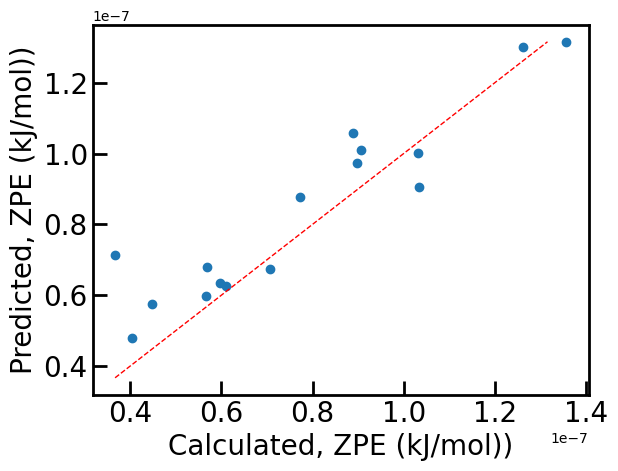

GB 0.7854336141005785
RMSE:  0.10930966851580368
RMSE unscaled:  1.3279184235860376e-08
----------------------------------------


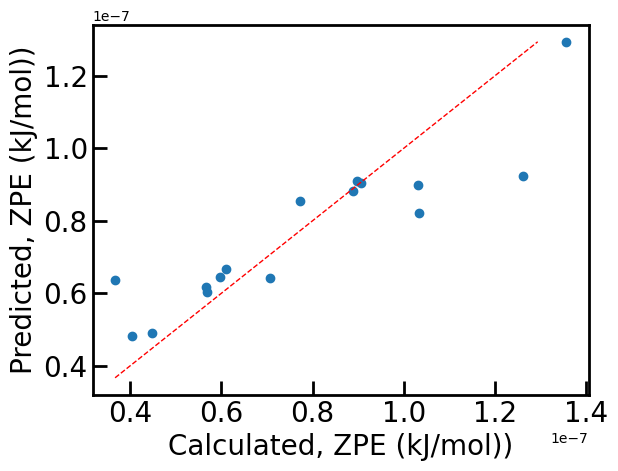

RR 0.8273287583959554
RMSE:  0.09805906325127027
RMSE unscaled:  1.1912435419390584e-08
----------------------------------------


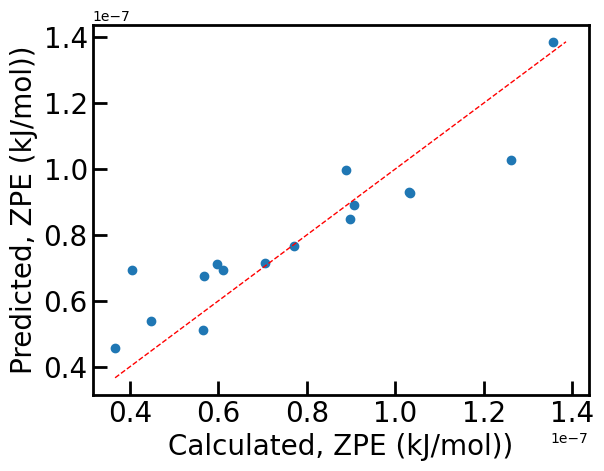

LASSO 0.6442251514354955
RMSE:  0.14075549404384388
RMSE unscaled:  1.7099293804440717e-08
----------------------------------------


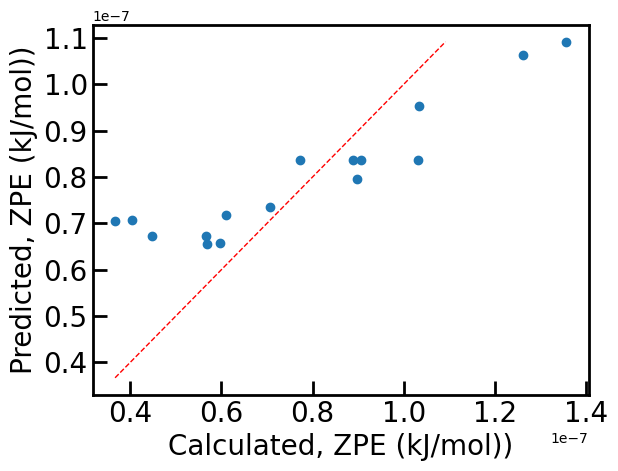

gpr1 0.8784913134885707
RMSE:  0.08225861583316496
RMSE unscaled:  9.992961551040961e-09
----------------------------------------


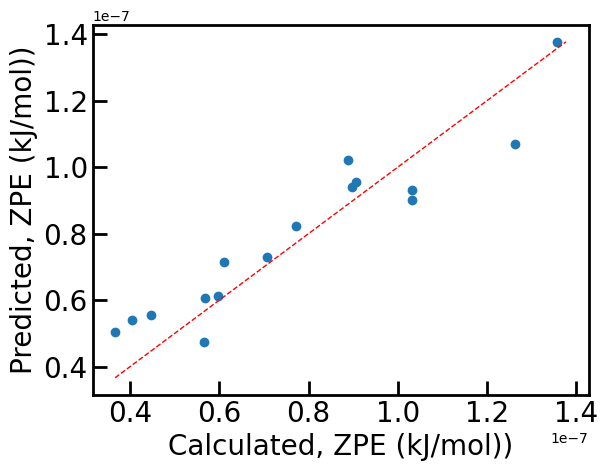

gpr2 -0.028188495091296728
RMSE:  0.2392842447764894
RMSE unscaled:  2.906878791482493e-08
----------------------------------------


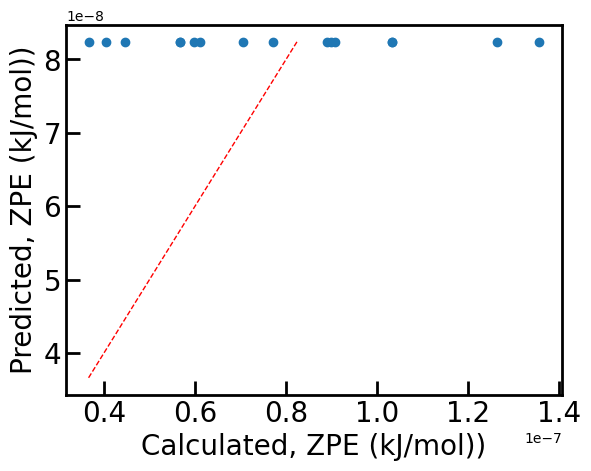

gpr3 0.9435579165389434
RMSE:  0.0560633767962715
RMSE unscaled:  6.810705031591185e-09
----------------------------------------


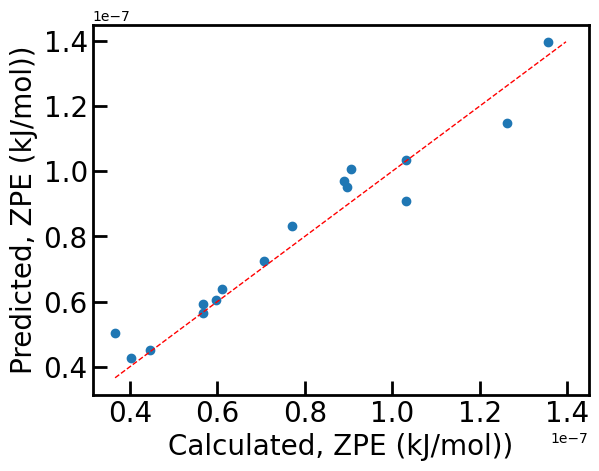

gpr4 0.9020324613262766
RMSE:  0.07386162067759543
RMSE unscaled:  8.972875704908202e-09
----------------------------------------


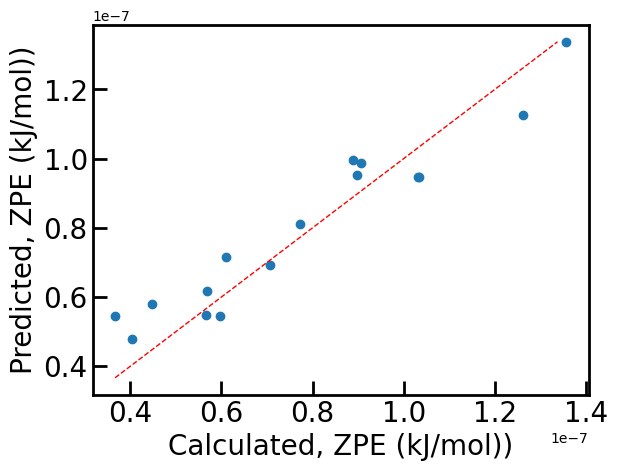

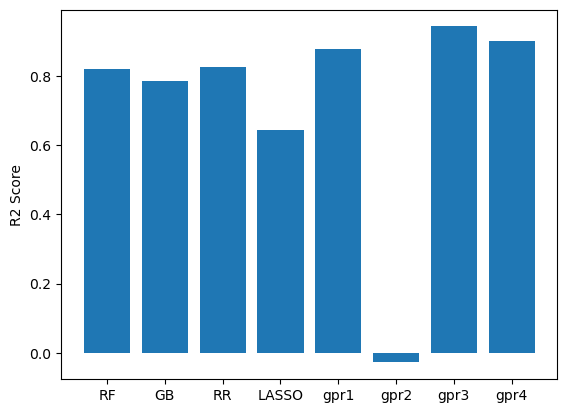

In [28]:
run_models()

## Feature selection


In [29]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  109.296724
2        s_X   88.595605
28      X_EA   73.368669
35      X_Ra   73.296860
17       X_Z   66.718735
7   mean_X2X   56.945060
33    A_Rvdw   51.699207
0        s_A   41.011777
5   mean_A2X   40.526215
1        s_B   33.215949
20     A_IEI   32.506577
12     E_coh   30.740923
31    A_ChiA   16.249435
9    std_A2X   15.249756
29    A_ChiP   14.642045
25    X_IEII   14.270340
26      A_EA   13.518905
42      B_Hf   13.440569
45   X_Kappa   12.439648
36      B_MP   11.182324
37      A_BP   10.591541
43   A_Kappa    8.683247
32    X_ChiA    8.650691
10   std_B2X    8.580932
15       A_Z    8.474870
44   B_Kappa    8.031022
16       B_Z    6.255140
46     A_CvM    5.656104
18       A_G    5.063472
14        OF    4.732281


In [30]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_EA', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'X_IEII', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP', 'A_BP',
       'A_Kappa', 'X_ChiA', 'std_B2X', 'A_Z', 'B_Kappa', 'B_Z', 'A_CvM',
       'A_G', 'OF', 'B_Ra', 'X_IEI', 'A_B', 'std_A2B', 'B_EA', 'B_Rho',
       'X_MV', 'density', 'B_IEI', 'B_ChiP'], dtype=object)

In [31]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.8182079242092647
RMSE:  0.10061557386741787
RMSE unscaled:  1.2223006075524708e-08
----------------------------------------


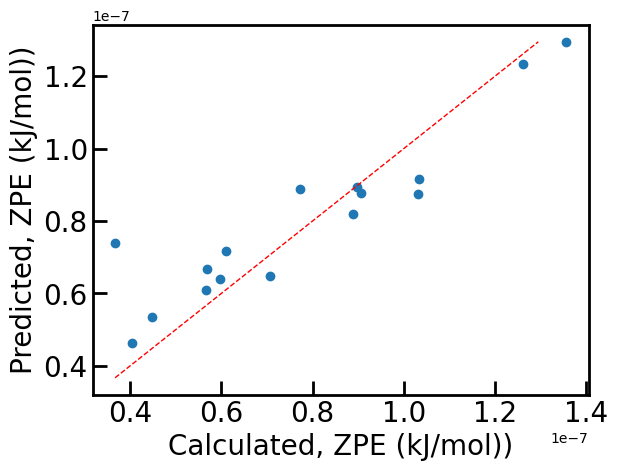

GB 0.8136709988997386
RMSE:  0.10186335171307327
RMSE unscaled:  1.2374588932950422e-08
----------------------------------------


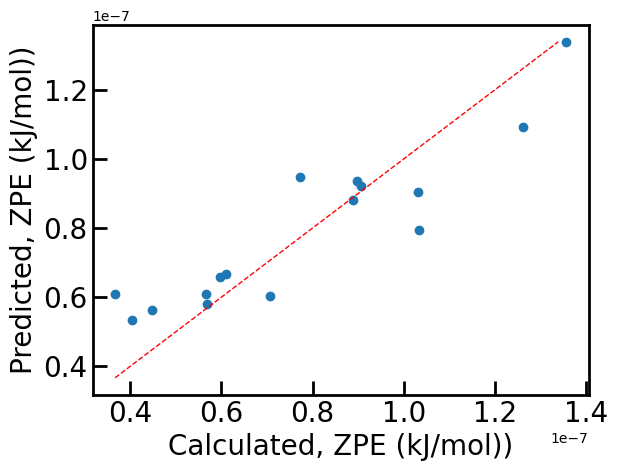

RR 0.8202485637869678
RMSE:  0.10004926875137347
RMSE unscaled:  1.2154210057095867e-08
----------------------------------------


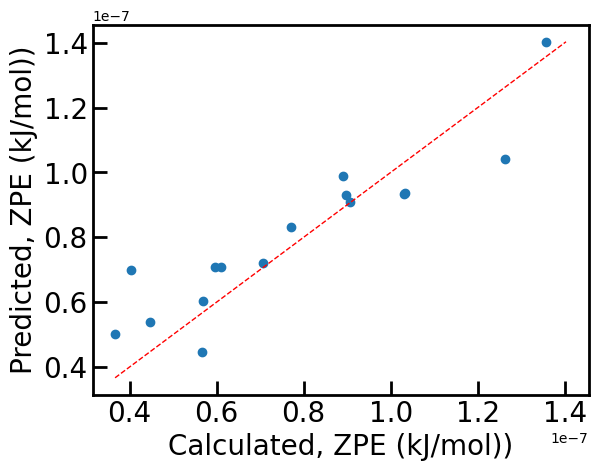

LASSO 0.6442260904249495
RMSE:  0.1407553082971389
RMSE unscaled:  1.709927123951348e-08
----------------------------------------


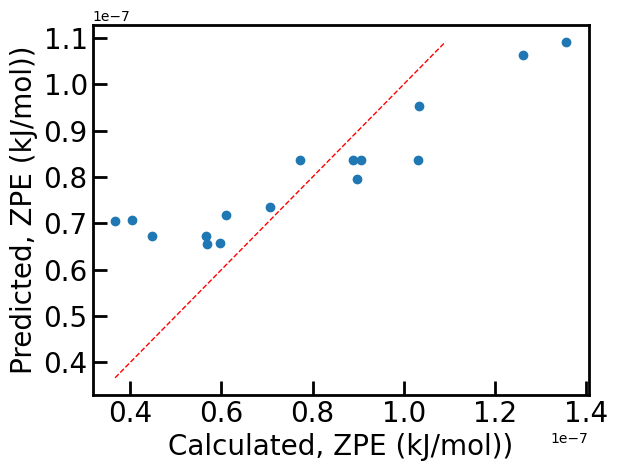

gpr1 0.8646979660750428
RMSE:  0.08680203297313727
RMSE unscaled:  1.054490607782667e-08
----------------------------------------


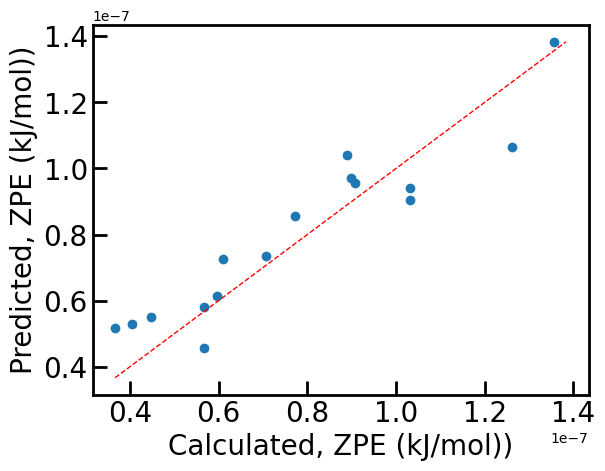

gpr2 -0.028188492719006586
RMSE:  0.23928424450044483
RMSE unscaled:  2.906878788129042e-08
----------------------------------------


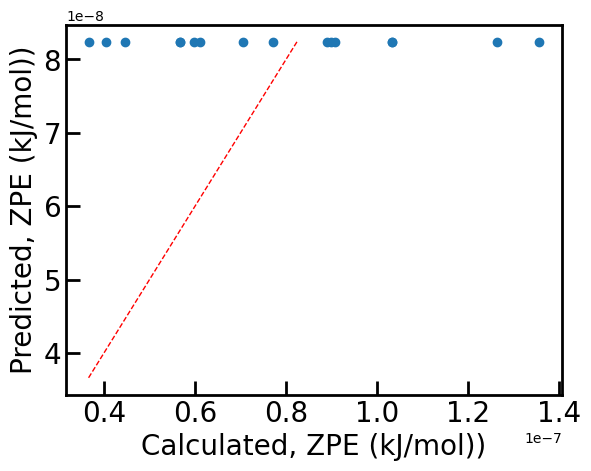

gpr3 0.9212045053703655
RMSE:  0.06624123598498255
RMSE unscaled:  8.04713424346825e-09
----------------------------------------


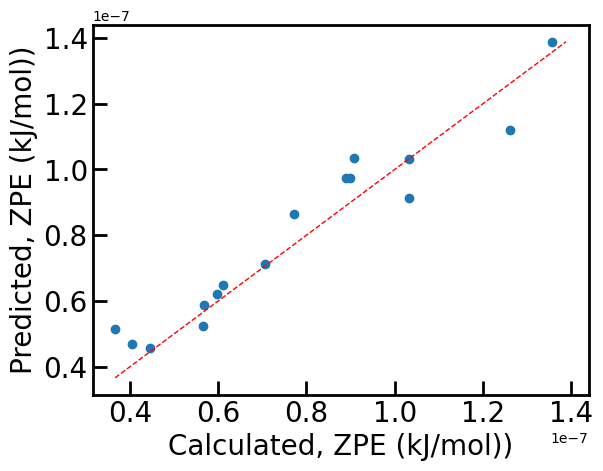

gpr4 0.8964787223450122
RMSE:  0.07592635408263172
RMSE unscaled:  9.223704160027414e-09
----------------------------------------


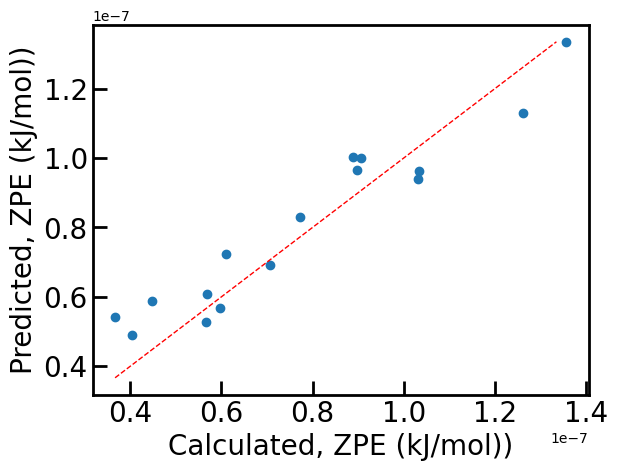

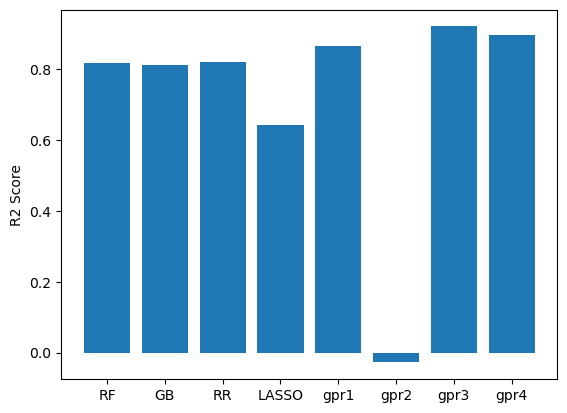

In [32]:
run_models()

In [33]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_EA', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'X_IEII', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP', 'A_BP',
       'A_Kappa', 'X_ChiA', 'std_B2X', 'A_Z', 'B_Kappa', 'B_Z', 'A_CvM',
       'A_G', 'OF'], dtype=object)

In [34]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.8540582349432243
RMSE:  0.09015037372122792
RMSE unscaled:  1.0951670038252605e-08
----------------------------------------


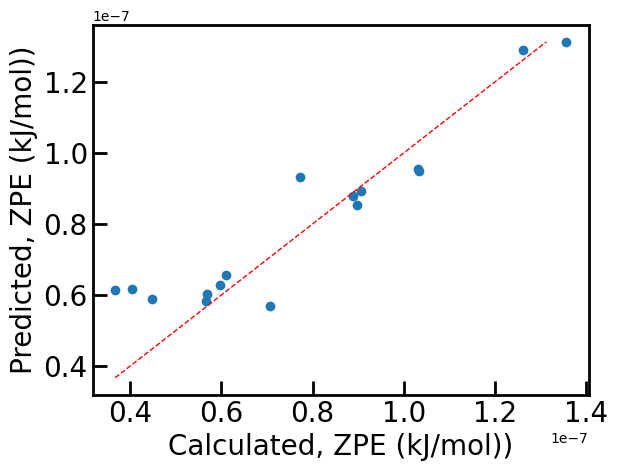

GB 0.7668388899824254
RMSE:  0.11394775977937359
RMSE unscaled:  1.3842629987987733e-08
----------------------------------------


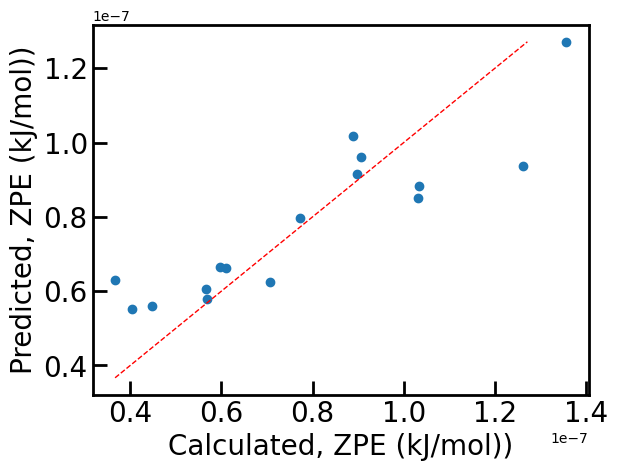

RR 0.8054790289202712
RMSE:  0.10407848184886319
RMSE unscaled:  1.2643687920980997e-08
----------------------------------------


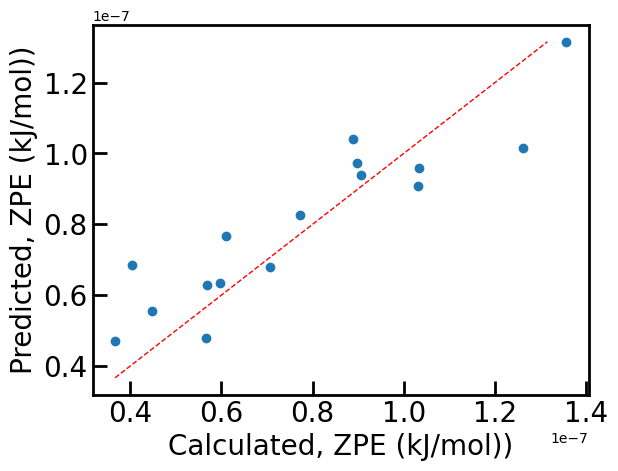

LASSO 0.6442260904249495
RMSE:  0.1407553082971389
RMSE unscaled:  1.709927123951348e-08
----------------------------------------


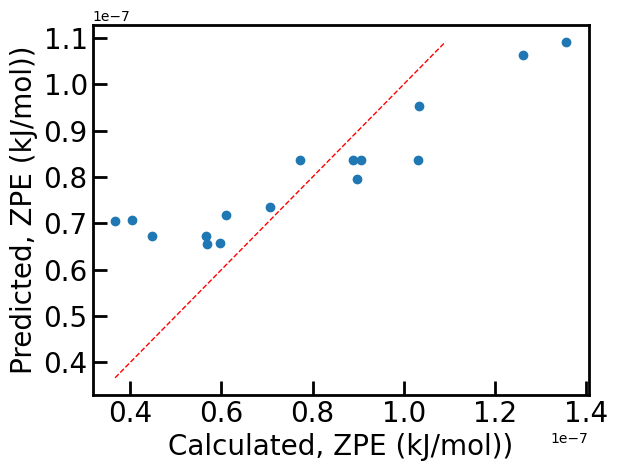

gpr1 0.867610447122956
RMSE:  0.08586271007409897
RMSE unscaled:  1.0430795020656197e-08
----------------------------------------


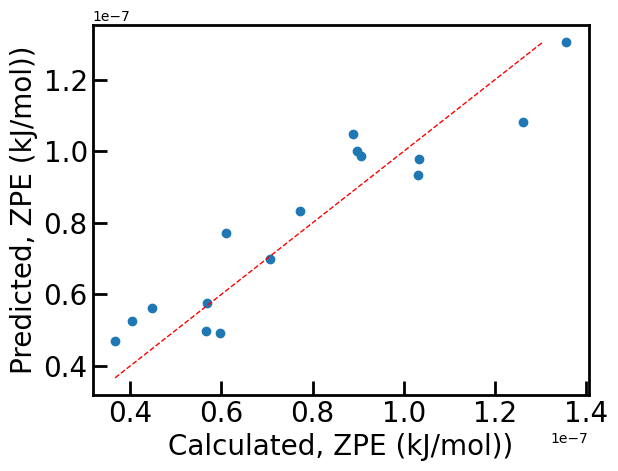

gpr2 -0.02818849484633601
RMSE:  0.23928424474798526
RMSE unscaled:  2.9068787911362183e-08
----------------------------------------


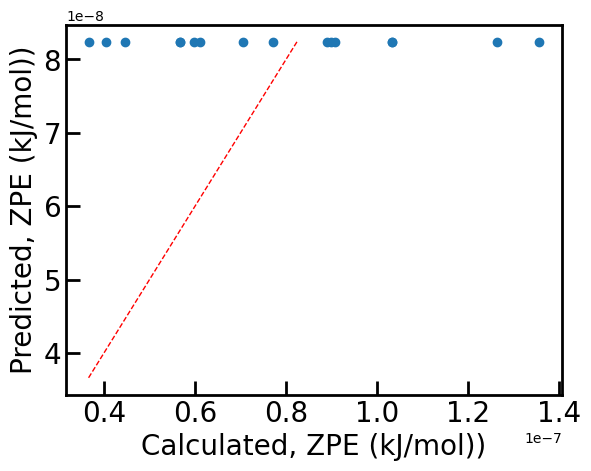

gpr3 0.9162088523244378
RMSE:  0.06830882322711766
RMSE unscaled:  8.298309389133037e-09
----------------------------------------


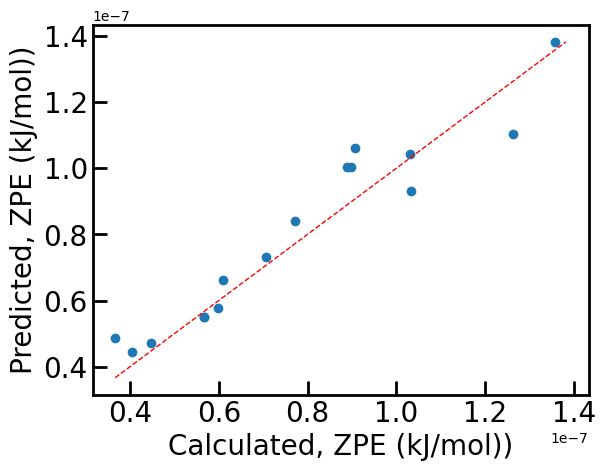

gpr4 0.9119431103592127
RMSE:  0.07002601376687444
RMSE unscaled:  8.506917555776688e-09
----------------------------------------


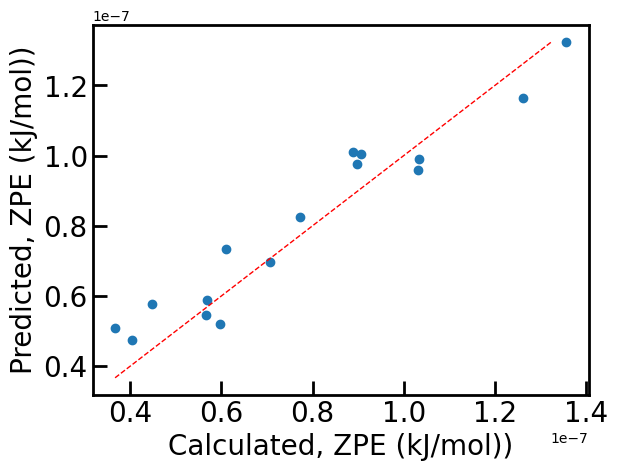

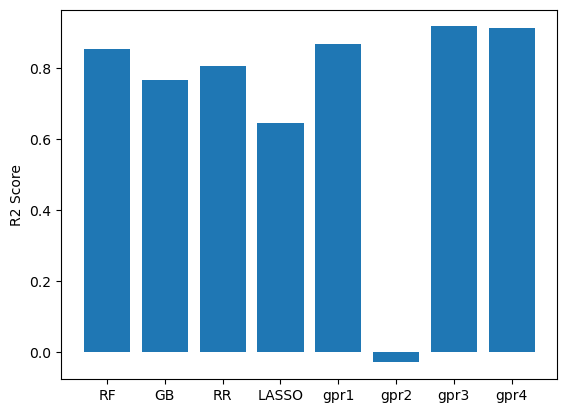

In [35]:
run_models()

In [36]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_EA', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'A_ChiP', 'X_IEII', 'A_EA', 'B_Hf', 'X_Kappa', 'B_MP'],
      dtype=object)

In [37]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.8812226219467872
RMSE:  0.08132884437909559
RMSE unscaled:  9.880010824874903e-09
----------------------------------------


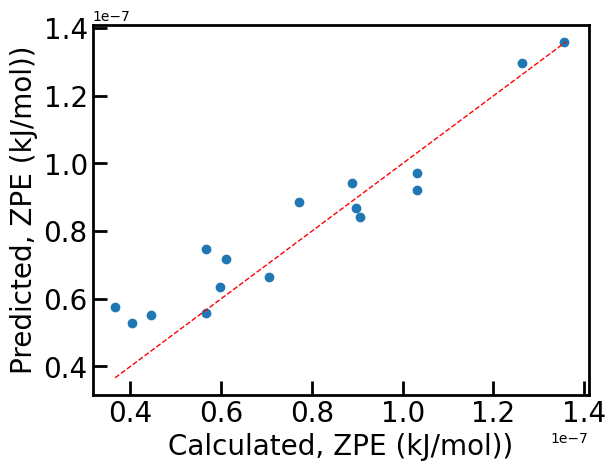

GB 0.8627104731098278
RMSE:  0.0874372395986109
RMSE unscaled:  1.0622072406496707e-08
----------------------------------------


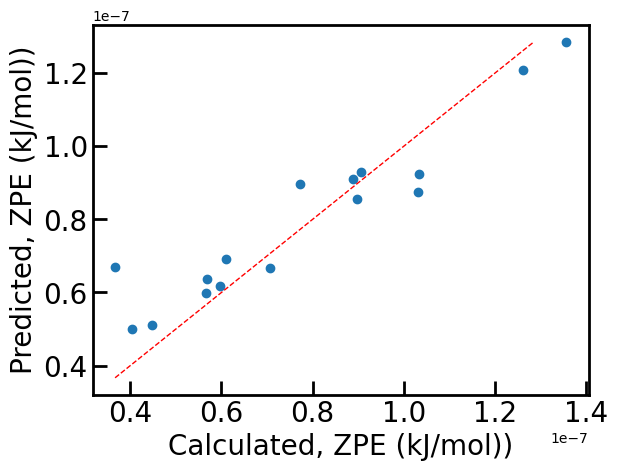

RR 0.8866590085131115
RMSE:  0.0794458540238903
RMSE unscaled:  9.651260923968344e-09
----------------------------------------


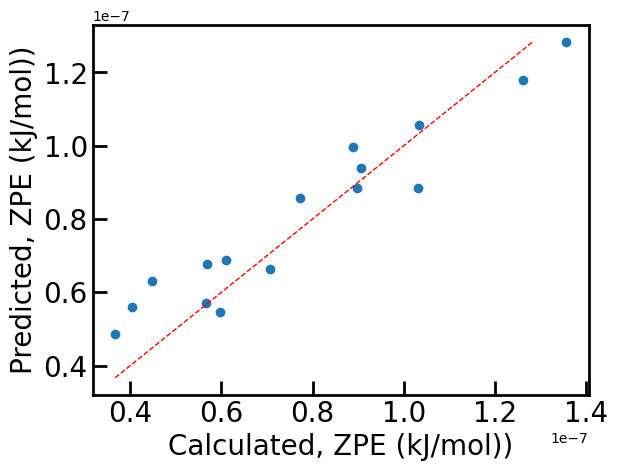

LASSO 0.6442260904249495
RMSE:  0.1407553082971389
RMSE unscaled:  1.709927123951348e-08
----------------------------------------


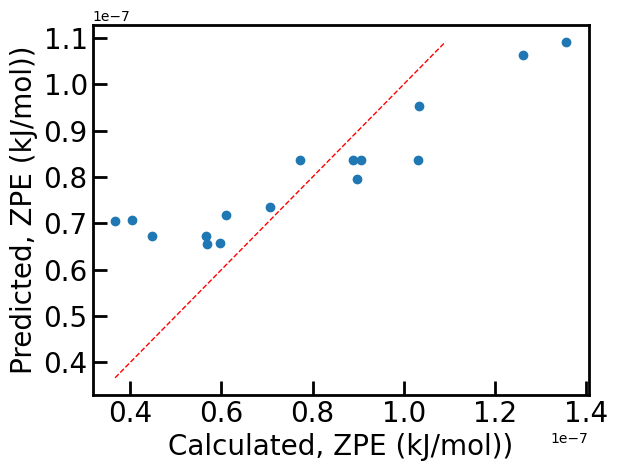

gpr1 0.9141117743739796
RMSE:  0.06915833827701337
RMSE unscaled:  8.40151038692099e-09
----------------------------------------


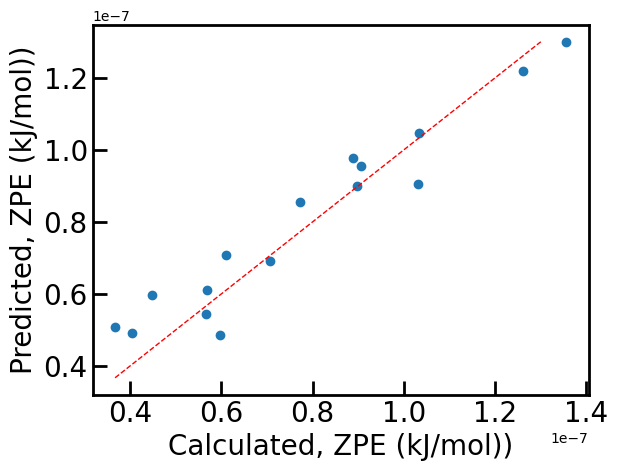

gpr2 -0.02818849542844548
RMSE:  0.23928424481572072
RMSE unscaled:  2.906878791959084e-08
----------------------------------------


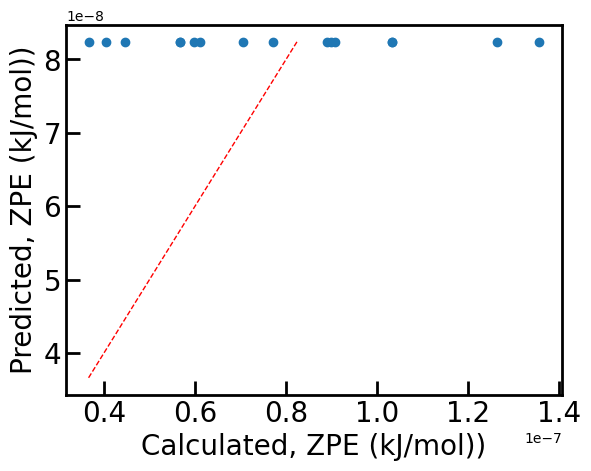

gpr3 0.9121066739566361
RMSE:  0.06996094770296551
RMSE unscaled:  8.49901318407855e-09
----------------------------------------


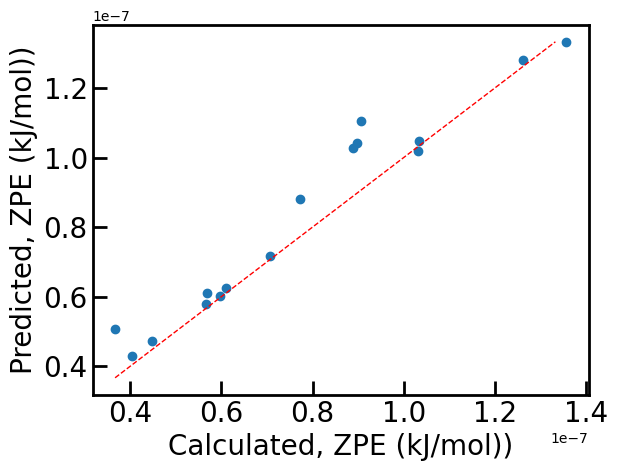

gpr4 0.9101075251109514
RMSE:  0.07075211111570363
RMSE unscaled:  8.595125493822703e-09
----------------------------------------


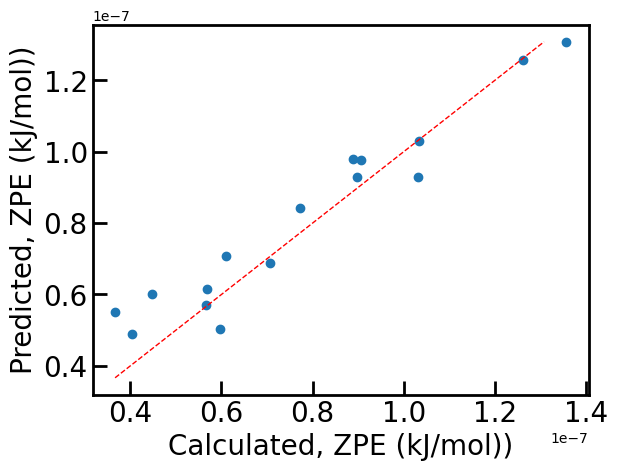

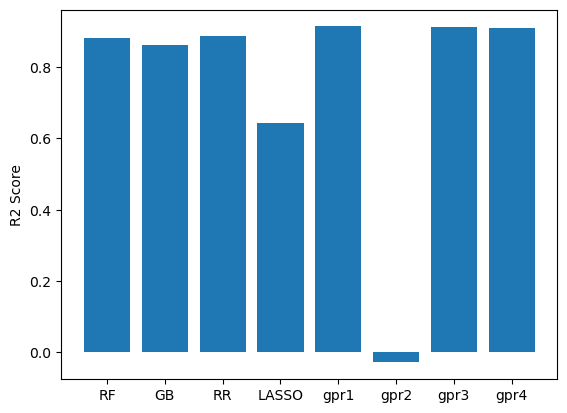

In [38]:
run_models()

In [39]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_EA', 'X_Ra', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B'], dtype=object)

In [40]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8514453348345639
RMSE:  0.09095380696851517
RMSE unscaled:  1.1049272915077727e-08
----------------------------------------


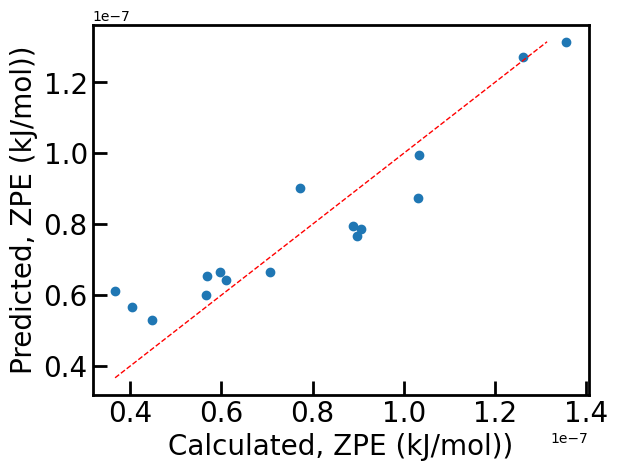

GB 0.8828258204211022
RMSE:  0.08077811136769181
RMSE unscaled:  9.813106540720534e-09
----------------------------------------


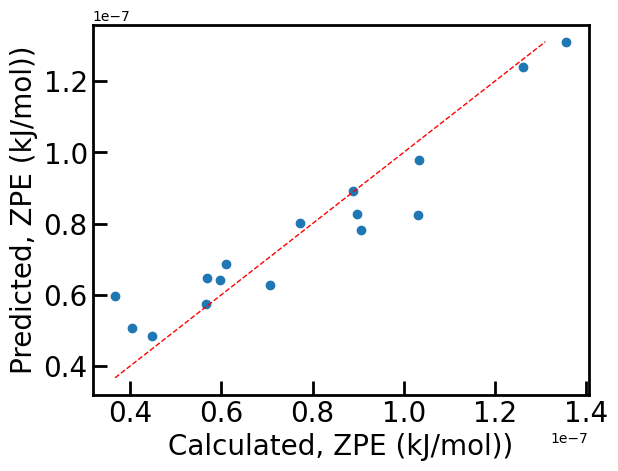

RR 0.9282660915297851
RMSE:  0.0632033330253235
RMSE unscaled:  7.678082963378187e-09
----------------------------------------


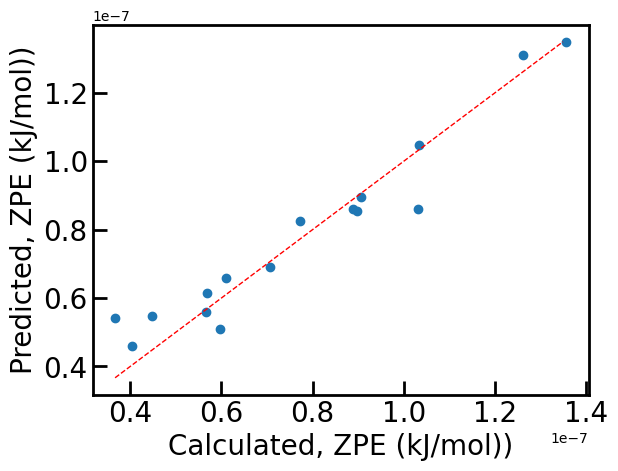

LASSO 0.6442260904249495
RMSE:  0.1407553082971389
RMSE unscaled:  1.709927123951348e-08
----------------------------------------


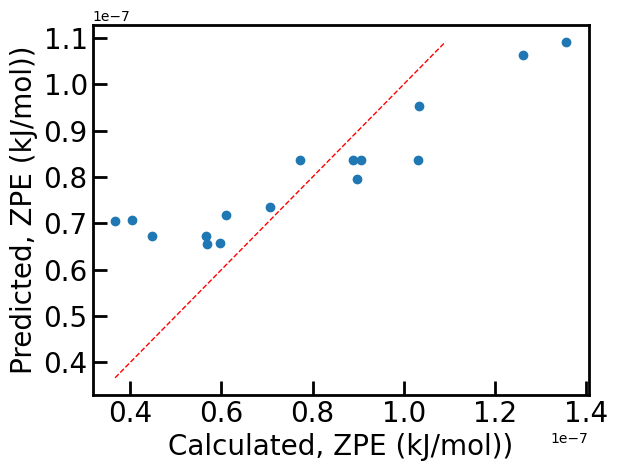

gpr1 0.899514745433711
RMSE:  0.07480470296427089
RMSE unscaled:  9.087443460939127e-09
----------------------------------------


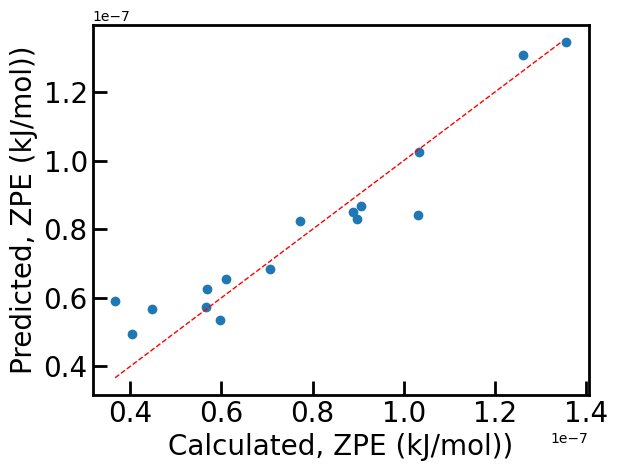

gpr2 -0.028188516706441513
RMSE:  0.23928424729167197
RMSE unscaled:  2.9068788220374963e-08
----------------------------------------


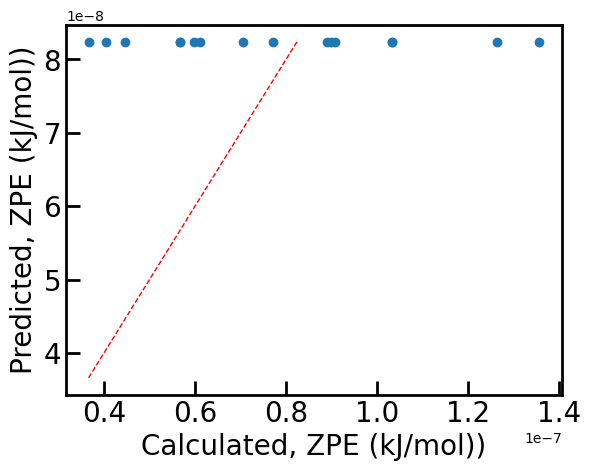

gpr3 0.9388001807918758
RMSE:  0.05837848278951103
RMSE unscaled:  7.091949311508908e-09
----------------------------------------


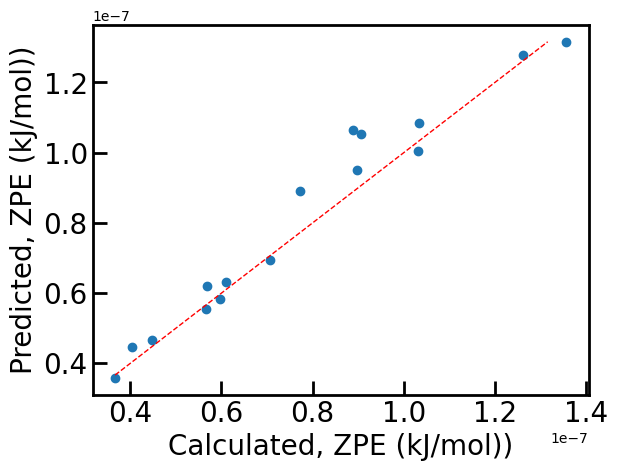

gpr4 0.9337855089561268
RMSE:  0.06072314502745017
RMSE unscaled:  7.376784150468803e-09
----------------------------------------


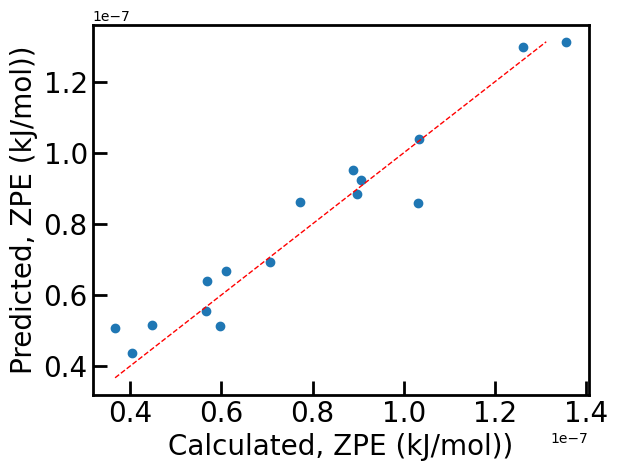

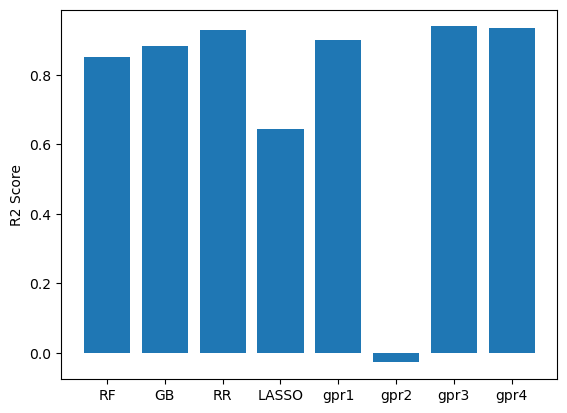

In [41]:
run_models()